In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [2]:
epsilons = [0.2, 0.15, 0.1, 0.05]

def epsilon_to_num_samples(num_consumers, num_goods, epsilon, delta, c, excluded_pairs):
    ser = np.ceil(np.log((2.0 * num_consumers * num_goods - len(excluded_pairs)) / delta) * 0.5 * (c / epsilon) * (c / epsilon)) * num_consumers * num_goods
    ser = ser.astype('int64')
    return ser

def add_ea_num_samples(data, eps_col_name):
    data['ea_num_samples'] = epsilon_to_num_samples(data['num_consumers'], 
                                             data['num_goods'], 
                                             data[eps_col_name], 
                                             0.1, 
                                             data['noise_factor'] + 10.0, 
                                             set())
def add_savings_col(data):
    add_ea_num_samples(data, 'final_epsilon')
    data['savings'] = (1.0 - (data['total_num_samples'] / data['ea_num_samples'])) * 100.0
    return data

def select_data(data, selectors):
    res = data
    for col, val in selectors.items():
        if val is not None:
            res = res[res[col] == val]
    return res

def get_stats(data):
    return data['savings'].mean()

def get_summary(x, type_of_market = None, target_eps = None):
    result = []
    for num_c in [5, 10, 15, 20]:
        res = []
        for num_g in [5, 10, 15, 20]:
            res += [get_stats(select_data(x, {'type_market' : type_of_market, 
                                              'num_consumers' : num_c, 
                                              'num_goods': num_g,
                                              'target_eps': target_eps
                                             }))]
        result += [res]
    return np.array(result)

In [3]:
results_dir = '../results/'
data = pd.concat([pd.read_csv(f'{results_dir}results_eap_{source}.csv') for source in ['enrique', 'karina', 'grid']])
data = add_savings_col(data)
x = data.groupby(['num_consumers', 'num_goods', 'type_market', 'noise_factor', 'target_eps']).mean().reset_index()
data.columns

Index(['num_consumers', 'num_goods', 'type_market', 'noise_factor',
       'target_eps', 'final_epsilon', 'total_num_samples', 'total_pruned_0',
       'total_pruned_1', 'total_pruned_2', 'ea_num_samples', 'savings'],
      dtype='object')

In [4]:
market_name = {'uniform_random_distribution' : 'Uniform',
               'preferred_good_distribution': 'Preferred-Good',
               'preferred_distinct_good_distribution': 'Preferred-Good-Distinct',
               'preferred_subset_distribution': 'Preferred-Subset'}

cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

def heatmap(type_of_market, eps, the_cmap, loc):
    data = np.flip(get_summary(x,type_of_market=type_of_market, target_eps=eps), 0)
    ax = sns.heatmap(data, 
                     annot=True, 
                     cmap=the_cmap, 
                     xticklabels=[i for i in [5, 10, 15, 20]],
                     yticklabels=[j for j in [20, 15, 10, 5]],
                     vmax=70, # This value is data dependent
                     vmin=25, # This value is data dependent
                    ax = loc)
    ax.set_xlabel('Number of Goods')
    ax.set_ylabel('Number of Buyers')
    #ax.set_title(f'EAP data relative savings (as a % of EA samples), eps = {eps}, \n market = {type_of_market}')
    ax.set_title(f'{market_name[type_of_market]}')
    plt.tight_layout()
    #plt.savefig(f'/Users/enriqueareyan/Documents/workspace/noisyce/plots/eap_savings_eps_{eps}_type_{type_of_market}.png', figsize=(1, 1), dpi=150)

<ipython-input-5-81f1d1b17df2>:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'/Users/enriqueareyan/Documents/workspace/noisyce/plots/eap_savings_eps_{eps}.png', figsize=(1, 1), dpi=150)


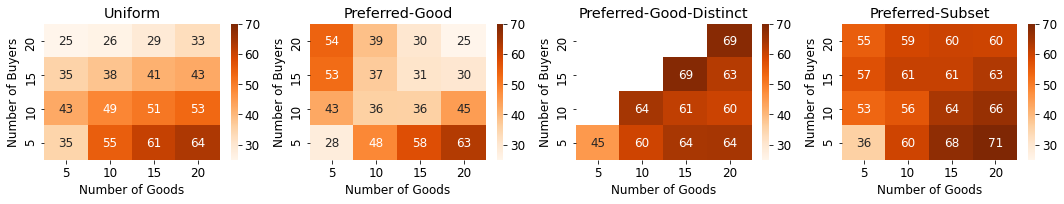

In [5]:
type_of_markets = ['uniform_random_distribution',
                   'preferred_good_distribution',
                   'preferred_distinct_good_distribution',
                   'preferred_subset_distribution']

font = {'size': 12}
matplotlib.rc('font', **font)

#fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 8.5))  # Size for only 4 plots, 2 by 2
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 3))  # Size for only 4 plots, 1 by 4
eps = 0.05
heatmap(type_of_markets[0], eps, cmaps[4], axs[0])
heatmap(type_of_markets[1], eps, cmaps[4], axs[1])
heatmap(type_of_markets[2], eps, cmaps[4], axs[2])
heatmap(type_of_markets[3], eps, cmaps[4], axs[3])
plt.savefig(f'/Users/enriqueareyan/Documents/workspace/noisyce/plots/eap_savings_eps_{eps}.png', figsize=(1, 1), dpi=150)